In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt
%matplotlib inline

Features: 
* Area_type - describes the area 
* Availability - when it can be possessed or when it is ready(categorical and time-series) 
* Location - where it is located in Bengaluru 
* Price - Value of the property in lakhs(INR) 
* Size - in BHK or Bedroom (1-10 or more) 
* Society - to which society it belongs 
* Total_sqft - size of the property in sq.ft
* Bath - No. of bathrooms 
* Balcony - No. of  balconies

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
print(train.shape, test.shape)

(13320, 9) (1480, 9)


In [3]:
train['source'] = 'Train'
test['source'] = 'Test'

data = pd.concat([train, test], ignore_index=True)
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,Train
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Train
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,Train
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,Train
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,Train


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     14800 non-null  object 
 1   availability  14800 non-null  object 
 2   location      14799 non-null  object 
 3   size          14782 non-null  object 
 4   society       8672 non-null   object 
 5   total_sqft    14800 non-null  object 
 6   bath          14720 non-null  float64
 7   balcony       14122 non-null  float64
 8   price         13320 non-null  float64
 9   source        14800 non-null  object 
dtypes: float64(3), object(7)
memory usage: 1.1+ MB


* `total_sqft` feature has not been infered as numeric. Lets fix that column before proceeding with the exploratory data analysis.

We need to know which values can´t be converted into numeric:

In [5]:
total_sqft = data['total_sqft'].values.tolist()
not_numeric = []

for i in range(len(total_sqft)):
    try:
        float(total_sqft[i])
    except:
        not_numeric.append(total_sqft[i])

In [6]:
not_numeric

['2100 - 2850',
 '3010 - 3410',
 '2957 - 3450',
 '3067 - 8156',
 '1042 - 1105',
 '1145 - 1340',
 '1015 - 1540',
 '1520 - 1740',
 '34.46Sq. Meter',
 '1195 - 1440',
 '1200 - 2400',
 '4125Perch',
 '1120 - 1145',
 '4400 - 6640',
 '3090 - 5002',
 '4400 - 6800',
 '1160 - 1195',
 '1000Sq. Meter',
 '4000 - 5249',
 '1115 - 1130',
 '1100Sq. Yards',
 '520 - 645',
 '1000 - 1285',
 '3606 - 5091',
 '650 - 665',
 '633 - 666',
 '5.31Acres',
 '30Acres',
 '1445 - 1455',
 '884 - 1116',
 '850 - 1093',
 '1440 - 1884',
 '716Sq. Meter',
 '547.34 - 827.31',
 '580 - 650',
 '3425 - 3435',
 '1804 - 2273',
 '3630 - 3800',
 '660 - 670',
 '4000 - 5249',
 '1500Sq. Meter',
 '620 - 933',
 '142.61Sq. Meter',
 '2695 - 2940',
 '2000 - 5634',
 '1574Sq. Yards',
 '3450 - 3472',
 '1250 - 1305',
 '670 - 980',
 '1005.03 - 1252.49',
 '3630 - 3800',
 '1004 - 1204',
 '361.33Sq. Yards',
 '645 - 936',
 '2710 - 3360',
 '2249.81 - 4112.19',
 '3436 - 3643',
 '2830 - 2882',
 '596 - 804',
 '1255 - 1863',
 '1300 - 1405',
 '1200 - 2400',


Some of the values come in different units, so they must be converted to sqft. Others are in between two values and we will calculate the mean.

Possible different measurements units and its equivalence in sqft:
* 1 Sq. Meter = 10.7639 sqft
* 1 Perch = 272.25 sqft
* 1 Sq. Yards = 9 sqft
* 1 Acres = 43560 sqft
* 1 Cents = 435.6 sqft
* 1 Guntha = 1.089 sqft
* 1 Grounds = 2400 sqft

The following function converts to square feet the area. It needs a dataframe, a sting containing the measurement unit and its equivalence in square feet.

In [7]:
def convert_to_sqft (df, measure, equivalence_in_sqft):
    df_temp = df[df.total_sqft.str.contains(measure, na=False)]
    if df_temp.shape[0]>0:
        df_temp = df_temp.total_sqft.str.split(pat = measure, expand=True)
        df_temp.drop(columns = 1,inplace = True)
        df_temp.columns = ['total_sqft']
        df_temp.total_sqft = df_temp.total_sqft.astype(float) * equivalence_in_sqft
        ind = df_temp.index.values.tolist()

        for i in ind:
            df.loc[i, 'total_sqft'] = df_temp.loc[i, 'total_sqft']
    
    return df;

In [8]:
convert_to_sqft(data, 'Sq. Yards', 9)
convert_to_sqft(data, 'Guntha', 1.089)
convert_to_sqft(data, 'Acres', 43560)
convert_to_sqft(data, 'Sq. Meter', 10.7639)
convert_to_sqft(data, 'Perch', 272.25)
convert_to_sqft(data, 'Cents', 435.6)
convert_to_sqft(data, 'Ground', 2400)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,Train
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Train
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,Train
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,Train
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,Train
...,...,...,...,...,...,...,...,...,...,...
14795,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,NaN,Test
14796,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,NaN,Test
14797,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,NaN,Test
14798,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,NaN,Test


The following function substitutes the values that have an interval by their mean.

In [9]:
#This function checks if there is a range in the area column and calculates the mean
def calculate_sqft_mean (df): 
    df_temp = df[df.total_sqft.str.contains(' - ', na=False)]
    if df_temp.shape[0]>0:
        df_temp = df_temp.total_sqft.str.split(pat = ' - ', expand=True)
        df_temp['total_sqft'] = (df_temp[0].astype(float)+df_temp[1].astype(float))/2
        ind = df_temp.index.values.tolist()
        
        for i in ind:
            df.loc[i, 'total_sqft'] = df_temp.loc[i, 'total_sqft']
        
    return df;

In [10]:
calculate_sqft_mean(data)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,Train
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Train
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,Train
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,Train
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,Train
...,...,...,...,...,...,...,...,...,...,...
14795,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,NaN,Test
14796,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,NaN,Test
14797,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,NaN,Test
14798,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,NaN,Test


Now we can try to convert the column into numeric:

In [11]:
data['total_sqft'] = data['total_sqft'].astype(float)

# Checking for Outliers

Next step is to check whether there are some values that might be removed.

In [12]:
import matplotlib.pyplot as plt

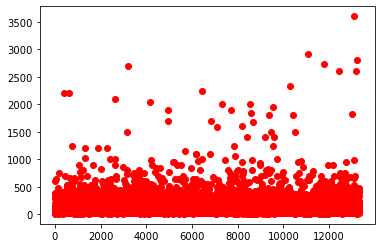

In [13]:
plt.scatter(data.index, data.price, color='r')

We will remove every house that has a price above percentile 90, we can come back later to try with different percentiles.

In [14]:
up_lim = data.price.quantile(0.9995)
print('Upper limit:', up_lim)

low_lim = data.price.quantile(0.0005)
print('Lower limit:', low_lim)

Upper limit: 2428.5300000000643
Lower limit: 10.0


In [15]:
x_up = list(data[data.price > up_lim].index)
y_up = data[data.price > up_lim]

x_lo = list(data[data.price < low_lim].index)
y_lo = data[data.price < low_lim]

x_in = list((data[data.price <= up_lim].index) & (data[data.price >= low_lim].index))
y_in = data[(data.price <= up_lim) & (data.price >= low_lim)]

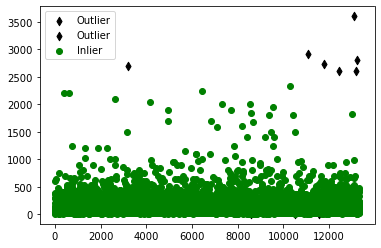

In [16]:
plt.scatter(x_up, y_up.price, color='black', marker='d', label='Outlier')
plt.scatter(x_lo, y_lo.price, color='black', marker='d', label='Outlier')
plt.scatter(x_in, y_in.price, color='green', label='Inlier')
plt.legend()

Although percentile 99.95 sets the upper limit in 2428.53, it can be seen that there are more cases that could be considered as outliers. Considering that there is no continuity in prices above 1500, I would consider an outlier every house with a price over that point. And the same happens for the lower limit, percentile 0.05 establish that limit in 10.00, but we shoud see if there are more houses for sale for that amount or if we should consider increasing that number:

In [17]:
data['price'].sort_values().head(20)

10526     8.00
11569     8.44
8594      9.00
5410     10.00
4113     10.00
1471     10.00
11091    10.00
7482     10.00
12579    10.00
11945    10.25
2437     10.25
8653     10.50
942      11.00
171      11.00
8725     11.50
8430     11.50
9599     11.50
9102     11.50
365      11.66
5154     12.00
Name: price, dtype: float64

Seeing those values I would not consider removing values under 10 either, there are just a few values and they are close to each other.

In [18]:
#Establishing new upper limit:
up_lim = 1500
x_up = list(data[data.price > up_lim].index)
y_up = data[data.price > up_lim]

x_in = list(data[data.price <= up_lim].index) 
y_in = data[data.price <= up_lim]

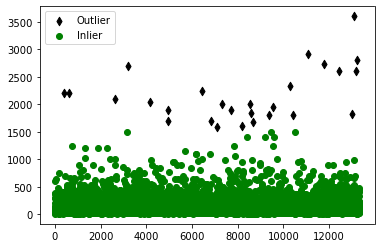

In [19]:
plt.scatter(x_up, y_up.price, color='black', marker='d', label='Outlier')
plt.scatter(x_in, y_in.price, color='green', label='Inlier')
plt.legend()

Since we are removing data depending on the `price` value, we have to fill the NaN values of the test set:

In [20]:
data.loc[data['source']=='Test', 'price'] = data.loc[data['source']=='Train', 'price'].mean()

In [21]:
data = data.loc[data.price <= up_lim]

# Exploratory Data Analysis

We start by looking some basic statistics of the variables:

In [22]:
data.describe(include='all')

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
count,14773,14773,14772,14755,8664,1.477300e+04,14693.000000,14104.000000,14773.000000,14773
unique,4,82,1357,32,2829,NaN,NaN,NaN,NaN,2
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,NaN,NaN,NaN,NaN,Train
freq,9726,11727,591,5739,92,NaN,NaN,NaN,NaN,13293
mean,NaN,NaN,NaN,NaN,NaN,1.870341e+03,2.693119,1.581254,108.820163,NaN
std,NaN,NaN,NaN,NaN,NaN,1.649328e+04,1.335938,0.818963,109.110384,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000,0.000000,8.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.100000e+03,2.000000,1.000000,52.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.280000e+03,2.000000,2.000000,78.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.683000e+03,3.000000,2.000000,112.565627,NaN


**QUANTITATIVE VARIABLES:**
* **total_sqft**: has a min value of 1 and a maximum of 1.306.800 which is also far from the percentile 75. The minimum and maximum values should be checked and removed
* **bath**: has a maximum of 40. This must be checked as well.

**QUALITATIVE VARIABLES:**
* **availability**: has 82 different values. We should try to group them into different categories to make this feature usable.
* **location**: has 1357 categories. We will have to discard this column since it has too many different values to extract information from it.
* **society**: has 2829 categories and many missing values. As with the previous one, this column can not be used and it will be removed.

### total_sqft

In [23]:
data[['total_sqft', 'source']].sort_values(by='total_sqft').head(20)

,total_sqft,source
4086,1.0000,Train
4972,5.0000,Train
349,11.0000,Train
1020,15.0000,Train
1122,24.0000,Train
6552,26.1360,Train
13414,40.0000,Test
11320,41.3820,Train
5970,45.0000,Train
11558,60.0000,Train


Houses with values equal or under 60 sqft should be removed, but since 40 is the minimum value of the test set, we will remove those values keeping the ones that belong to the test set:

In [24]:
data = data.loc[(data['total_sqft']>60) | (data['source']=='Test')]

In [25]:
data[['total_sqft', 'source']].sort_values(by='total_sqft', ascending=False).head(20)

,total_sqft,source
1086,1306800.000,Train
648,1123031.250,Train
7001,653400.000,Train
7607,653400.000,Train
11615,261360.000,Train
1019,231303.600,Train
13645,217800.000,Test
6333,91040.400,Train
7334,87120.000,Train
7726,54885.600,Train


Here there is a similar situation, it could be considered as an outlier every house above 55.000 sqft (around 51.000 if we use the mean and 3 times the standar deviation). 

In [26]:
data = data.loc[(data['total_sqft']<55000) | (data['source']=='Test')]

### Bath

In [27]:
data[['bath', 'source']].sort_values(by = 'bath', ascending=False).head(20)

,bath,source
4684,40.0,Train
1718,27.0,Train
11559,18.0,Train
14717,16.0,Test
3379,16.0,Train
3609,16.0,Train
4916,15.0,Train
1078,14.0,Train
10695,13.0,Train
9935,13.0,Train


The two houses with 40 and 27 baths will be removed as well. From that point on, can not be considered as outliers since the values decrease gradually.

In [28]:
data = data.loc[data['bath']<=18]

## Multivariate Analisys

### Correlation between numeric variables

The correlation between numeric variables can be observed with a heat map:

In [29]:
# Before the correlation is calculated, we shall remove the prices from the test set:
data.loc[data['source']=='Test', 'price'] = np.nan
# Removing the outlier in order to see the plot correctly
data_tmp = data.loc[data['total_sqft']<200000]

<AxesSubplot:>

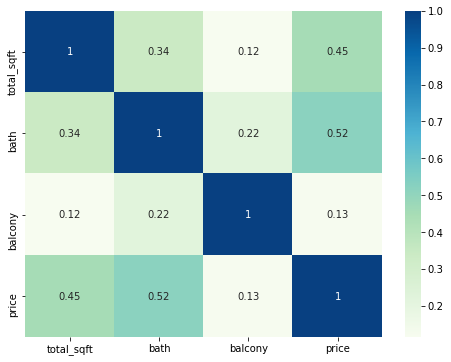

In [30]:
cor_mat = data_tmp.corr()
plt.figure(figsize=(8,6))
sns.heatmap(cor_mat, cmap='GnBu', annot=True)

Against what we could have thought, it seems that area and price are not the most correlated features in this set. There is a stronger correlation between price and the number of baths.

Since the heatmap only represents the intensity of linear relations between features, it is better to observe that realation with a pairplot:

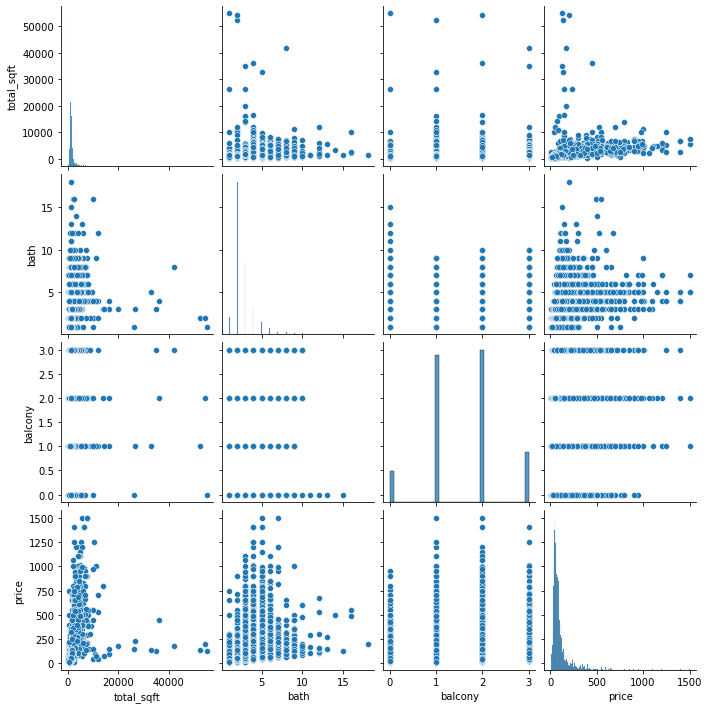

In [31]:
sns.pairplot(data_tmp, height=2.5)

Here it can be seen that there is still an outliers that drags out the relation between `price` and `total_sqft`. If we remove values from the test group:

In [32]:
data_tmp = data_tmp.loc[data['total_sqft']<=15000]

<AxesSubplot:>

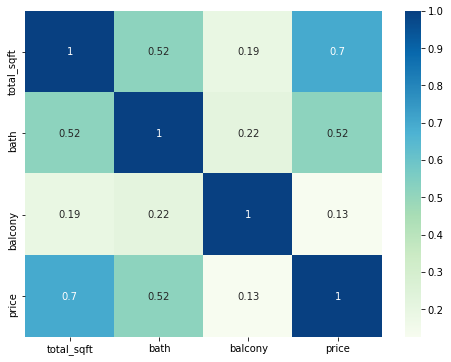

In [33]:
cor_mat = data_tmp.corr()
plt.figure(figsize=(8,6))
sns.heatmap(cor_mat, cmap='GnBu', annot=True)

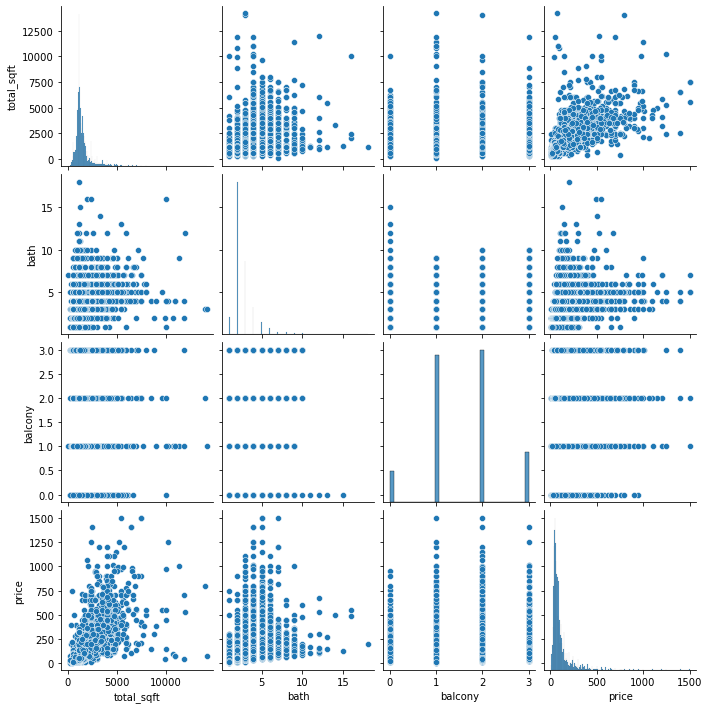

In [34]:
sns.pairplot(data_tmp, height=2.5)

Now it is clear that `total_sqft` and our target variable `price` are strongly correlated, moreover it also improved the intensity between `total_sqft` and `bath`.

# Null values

In [35]:
null_values = data.isnull().sum()
null_count = data.isnull().count() #Counts the number of rows
missing_perc = round(null_values/null_count * 100, 2)
df_missing = pd.DataFrame({'Null_Values': null_values, 'Percentage': missing_perc})
print(df_missing)

              Null_Values  Percentage
area_type               0        0.00
availability            0        0.00
location                1        0.01
size                    0        0.00
society              6090       41.50
total_sqft              0        0.00
bath                    0        0.00
balcony               587        4.00
price                1473       10.04
source                  0        0.00


<AxesSubplot:>

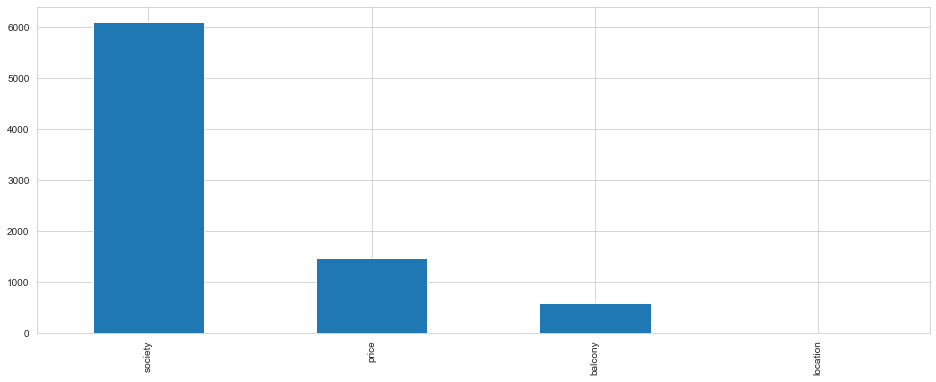

In [36]:
sns.set_style("whitegrid")
bars = df_missing.loc[df_missing['Percentage'].astype(float)>0]['Null_Values']
#.plot.bar(y='Percentage', figsize=(16,6))
bars.sort_values(ascending=False).plot(kind='bar', figsize=(16,6))

* **Society** has more than 40% of its values missing and there are 2826 unique values. This makes the imputation task very hard to implement and therefore, it will be removed.
* **Location** as we stated before, this column will also be removed.

In [37]:
data.drop(['society', 'location'], axis=1, inplace=True)

## Imputing Missing Values

### Balcony

We will be using size column to determine the most common number of balconies for every house size to impute the missing values:

In [38]:
#Determine the average of baths per house size:
balc_avg = data.pivot_table(values='balcony', index='size')
balc_avg = balc_avg.astype(int)
balc_avg

,balcony
size,
1 BHK,0
1 Bedroom,0
1 RK,0
10 Bedroom,2
11 BHK,3
11 Bedroom,1
12 Bedroom,2
13 BHK,0
14 BHK,0


This set does not have all the house sizes, so it is necessary to append the rest of them to avoid problems:

In [39]:
balc_avg.reset_index(inplace=True)

# Get all the house sizes:
all_sizes = set(data['size'].values)

# Get the ones that does not appear in the previous set:
no_balcony = list(all_sizes - set(balc_avg['size'].values))

no_balcony

['16 Bedroom', '10 BHK', '16 BHK', '18 Bedroom', '19 BHK']

In [40]:
np.zeros(len(no_balcony), dtype=int)

array([0, 0, 0, 0, 0])

In [41]:
no_balcony_data = pd.DataFrame({'size':no_balcony,
                               'balcony': np.zeros(len(no_balcony), dtype=int)})
no_balcony_data

,size,balcony
0,16 Bedroom,0
1,10 BHK,0
2,16 BHK,0
3,18 Bedroom,0
4,19 BHK,0


In [42]:
balc_avg.reset_index(inplace=True)

# Get all the house sizes:
all_sizes = set(data['size'].values)

# Get the ones that does not appear in the previous set:
no_balcony = list(all_sizes - set(balc_avg['size'].values))

#Create a dataframe with the sizes that don´t appear:
no_balcony_data = pd.DataFrame({'size':no_balcony,
                               'balcony': np.zeros(len(no_balcony), dtype=int)})

# Append those sizes with a value of 0:
balc_avg = pd.concat([balc_avg, no_balcony_data], ignore_index=True)
balc_avg

,index,size,balcony
0,0.0,1 BHK,0
1,1.0,1 Bedroom,0
2,2.0,1 RK,0
3,3.0,10 Bedroom,2
4,4.0,11 BHK,3
5,5.0,11 Bedroom,1
6,6.0,12 Bedroom,2
7,7.0,13 BHK,0
8,8.0,14 BHK,0
9,9.0,2 BHK,1


In [43]:
balc_avg.set_index('size', inplace=True)

In [44]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['balcony'].isnull() 
miss_bool

0        False
1        False
2        False
3        False
4        False
         ...  
14795    False
14796    False
14797    False
14798    False
14799    False
Name: balcony, Length: 14674, dtype: bool

In [45]:
#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool, 'balcony'] = data.loc[miss_bool, 'size'].apply(lambda x: balc_avg.loc[x])
print ('Final #missing: %d'% sum(data['balcony'].isnull()))

Orignal #missing: 587
Final #missing: 0


Now there should be no missing values (apart from the prices of the test set):

In [46]:
data.isnull().sum()

area_type          0
availability       0
size               0
total_sqft         0
bath               0
balcony            0
price           1473
source             0
dtype: int64

# Qualitative variables

## Availability

We will study if the availability column is related with the price or if it can be dropped:

In [47]:
data.pivot_table(index='availability', values='price').head(20)

,price
availability,
14-Jul,43.710000
14-Nov,43.710000
15-Aug,62.000000
15-Dec,130.000000
15-Jun,97.000000
15-Nov,125.000000
15-Oct,280.500000
16-Dec,130.000000
16-Jan,110.000000


We can group the availability column by month to see if there are months with a higher price:

In [48]:
#We have to reset the index since we have removed some rows:
data.reset_index(inplace = True)
data.drop(['index'], axis=1, inplace=True)
for i in range(len(data)):
    if(len(data.loc[i, 'availability'])==6):
        data.loc[i, 'availability'] = data.loc[i, 'availability'][3:]
        
data['availability'].value_counts()

Ready To Move    11696
Dec                809
May                365
Apr                322
Aug                277
Mar                261
Jul                227
Jun                213
Jan                138
Oct                 99
Nov                 92
Sep                 91
Feb                 84
Name: availability, dtype: int64

In [49]:
data.pivot_table(index='availability', values='price', 
                  aggfunc={'price':[np.mean, np.max,np.min]})

,amax,amin,mean
availability,,,
Apr,1150.0,15.00,93.506966
Aug,511.0,13.86,70.045221
Dec,995.0,13.26,93.663958
Feb,763.0,25.29,122.741081
Jan,1400.0,10.00,113.847769
Jul,1500.0,16.45,97.092059
Jun,488.0,14.00,89.213954
Mar,972.0,10.00,119.029641
May,815.0,19.80,95.702538


It can be seen that some months have maximum prices higher than others (`Jan`, `Jul` and the category `Ready To Move`) and they also have a higher mean. But this could not be due just to the availability feature, if we also calculate the max, min and mean of the total sqft that we already know that is correlated with the price:

In [50]:
#Keep just the trainning set since we need just the rows with a valid price
data2 = data.loc[data['source']=='Train'].reset_index()
data2.pivot_table(index='availability', values=['total_sqft','price'],
                  aggfunc={'total_sqft':[np.mean, np.max,np.min],
                           'price':[np.mean, np.max,np.min]})

price                    total_sqft                    
                 amax   amin        mean       amax   amin         mean
availability                                                           
Apr            1150.0  15.00   93.506966    10961.0  600.0  1432.555559
Aug             511.0  13.86   70.045221     3621.0  416.0  1292.092529
Dec             995.0  13.26   93.663958     5230.0  296.0  1469.808050
Feb             763.0  25.29  122.741081     4600.0  560.0  1606.851351
Jan            1400.0  10.00  113.847769     6500.0  509.0  1433.829680
Jul            1500.0  16.45   97.092059     7514.0  416.0  1478.739363
Jun             488.0  14.00   89.213954     5020.0  492.0  1457.557143
Mar             972.0  10.00  119.029641     7500.0  340.0  1593.392721
May             815.0  19.80   95.702538     5800.0  412.5  1495.921854
Nov             395.0  18.00   71.347911     4500.0  416.0  1327.417722
Oct             450.0  18.00   81.440899     4260.0  525.0  1485.092697
Ready To Move  1500.0   8.00  111.675833    54885.6  250.0  1580.257316
Sep             325.0  14.04   72.808512     3200.0  520.0  1344.306548

We can see that months with the lowest maximums of sale price (`Nov`, `Oct` and `Sep`) have also the lowest maximums of total_sqft, and this could explain those prices better than the month of sale. According to this, we are removing the availability column:

In [51]:
data.drop(['availability'], axis=1, inplace=True)

## Size

We can check if it is a good idea to combine different house sizes, there are different categories for 1 bedroom size (`1 BHK`, `1 Bedroom`, `1 RK`), for 2 bedroom size (`2 BHK`, `2 Bedroom`) and so on. A quick way to check that could be to analyze the mean prices by house size. If they have similar prices, then keeping them separate won’t help much.

In [52]:
sizes_avg = data.pivot_table(index='size', values='price')
sizes_avg

,price
size,
1 BHK,39.623547
1 Bedroom,71.498713
1 RK,28.122308
10 BHK,342.500000
10 Bedroom,285.000000
11 BHK,255.000000
11 Bedroom,160.000000
12 Bedroom,300.000000
13 BHK,275.000000


There are cases that this grouping could be a valid solution, for `6 BHK` and `6 Bedroom` or `9 BHK` and `9 Bedroom`, but not for others, so we will leave them this way for the moment.

# One-hot encoding of categorical variables

We need to convert all categorical variables to numerical since scikit-learn accepts only the latter. For that purpose, we will be using 'LabelEncoder' from sklearn´s preprocessing module.

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14674 entries, 0 to 14673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   14674 non-null  object 
 1   size        14674 non-null  object 
 2   total_sqft  14674 non-null  float64
 3   bath        14674 non-null  float64
 4   balcony     14674 non-null  float64
 5   price       13201 non-null  float64
 6   source      14674 non-null  object 
dtypes: float64(4), object(3)
memory usage: 802.6+ KB


In [54]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encoder
for i in ['area_type', 'size']:
    data[i] = le.fit_transform(data[i])
    
#One Hot Coding:
data = pd.get_dummies(data, columns=['area_type', 'size'])

data.dtypes

total_sqft     float64
bath           float64
balcony        float64
price          float64
source          object
area_type_0      uint8
area_type_1      uint8
area_type_2      uint8
area_type_3      uint8
size_0           uint8
size_1           uint8
size_2           uint8
size_3           uint8
size_4           uint8
size_5           uint8
size_6           uint8
size_7           uint8
size_8           uint8
size_9           uint8
size_10          uint8
size_11          uint8
size_12          uint8
size_13          uint8
size_14          uint8
size_15          uint8
size_16          uint8
size_17          uint8
size_18          uint8
size_19          uint8
size_20          uint8
size_21          uint8
size_22          uint8
size_23          uint8
size_24          uint8
size_25          uint8
size_26          uint8
size_27          uint8
size_28          uint8
size_29          uint8
dtype: object

# Exporting Data

We are getting back to the train and test data sets.

In [55]:
train = data.loc[data['source']=='Train']
test = data.loc[data['source']=='Test']

# Drop column source:
train.drop(['source'], axis=1, inplace=True)
test.drop(['source', 'price'], axis=1, inplace=True)

# Save the new files:
train.to_csv('train_modified.csv', index=False)
test.to_csv('train_modified.csv', index=False)

C:\Users\dtorrejon\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Model Building

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a **generic function** which takes the algorithm and data as input and **makes the model, performs cross-validation and generates submission**.

In [56]:
#Define target:
target = 'price'

from sklearn import metrics
from sklearn.model_selection import cross_val_score
def modelfit(alg, dtrain, dtest, predictors, target, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation with 20 partitions of the data:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    dtest.to_csv(filename, index=False)

## Linear Regression Model

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]]
predictors

['total_sqft',
 'bath',
 'balcony',
 'area_type_0',
 'area_type_1',
 'area_type_2',
 'area_type_3',
 'size_0',
 'size_1',
 'size_2',
 'size_3',
 'size_4',
 'size_5',
 'size_6',
 'size_7',
 'size_8',
 'size_9',
 'size_10',
 'size_11',
 'size_12',
 'size_13',
 'size_14',
 'size_15',
 'size_16',
 'size_17',
 'size_18',
 'size_19',
 'size_20',
 'size_21',
 'size_22',
 'size_23',
 'size_24',
 'size_25',
 'size_26',
 'size_27',
 'size_28',
 'size_29']

In [58]:
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, 'lr.csv')


Model Report
RMSE : 86.48
CV Score : Mean - 8.959e+12 | Std - 2.505e+13 | Min - 62.55 | Max - 8.583e+13


<ipython-input-56-a90f21494294>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


<AxesSubplot:>

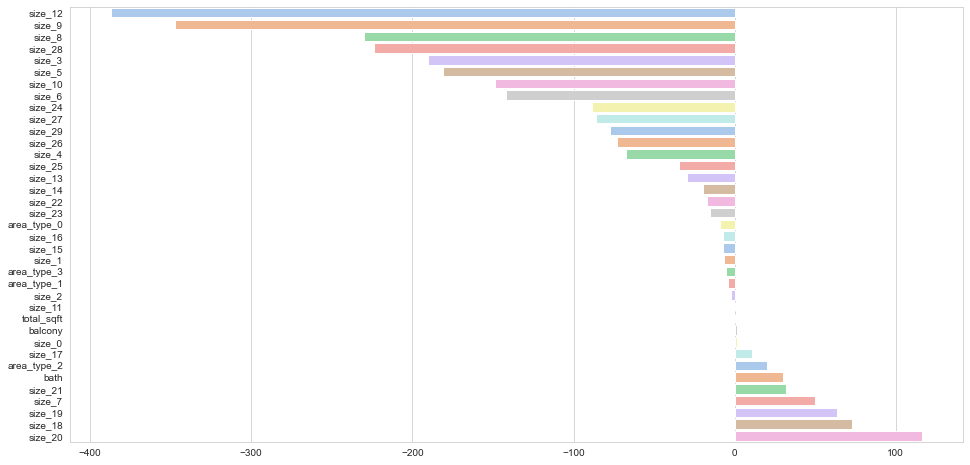

In [59]:
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
plt.figure(figsize=(16,8))
sns.barplot(x=coef1.values, y=coef1.index, orient='h', palette='pastel')

## Ridge Regression Model:


Model Report
RMSE : 86.53
CV Score : Mean - 86.89 | Std - 12.26 | Min - 62.42 | Max - 112.1


<ipython-input-56-a90f21494294>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


<AxesSubplot:>

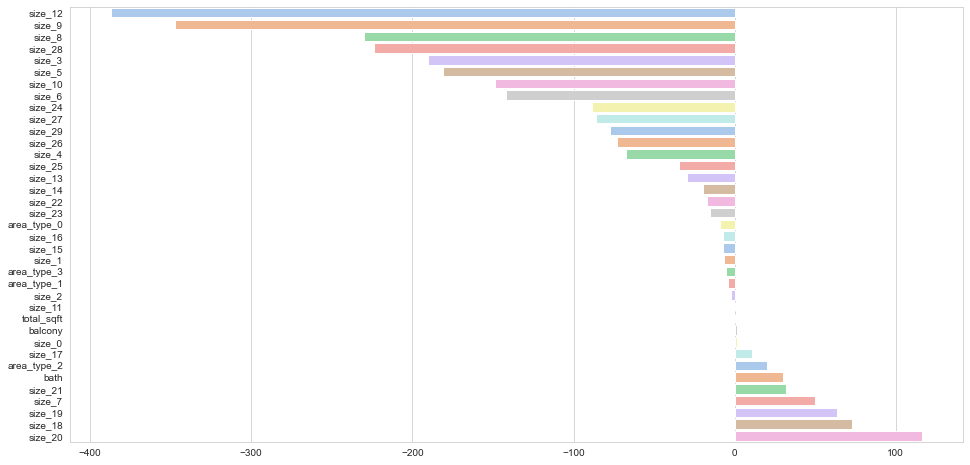

In [60]:
predictors = [x for x in train.columns if x not in [target]]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, 'ridge.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
plt.figure(figsize=(16,8))
sns.barplot(x=coef1.values, y=coef1.index, orient='h', palette='pastel')

## Decision Tree Model
Lets try out a decision tree model and see if we get something better.


Model Report
RMSE : 72.24
CV Score : Mean - 72.82 | Std - 9.71 | Min - 57.32 | Max - 93.99


<ipython-input-56-a90f21494294>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


<AxesSubplot:title={'center':'Feature Importances'}>

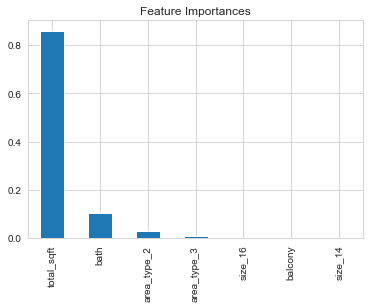

In [61]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, 'dcm.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3 = coef3.loc[coef3.values > 0]
coef3.plot(kind='bar', title='Feature Importances')

## Random Forest Model


Model Report
RMSE : 72.96
CV Score : Mean - 73.14 | Std - 10.1 | Min - 56.87 | Max - 97.22


<ipython-input-56-a90f21494294>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


<AxesSubplot:title={'center':'Feature Importances'}>

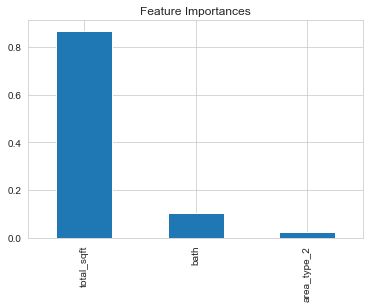

In [63]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]]
alg4 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg4, train, test, predictors, target, 'rfm.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4 = coef4.loc[coef4.values > 0.01]
coef4.plot(kind='bar', title='Feature Importances')

# Submission

The best model seems to be the one using the decision tree classifier, so I will use that one for submitting.